In [1]:
import nltk
from nltk.corpus import words
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import warnings
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import plotly.express as px

warnings.filterwarnings('ignore')

In [2]:
essays_df=pd.read_csv("data/train_essays.csv")

In [3]:
essays_df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [4]:
essays_df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [5]:
train_prompts_df=pd.read_csv("data/train_prompts.csv")

In [6]:
train_prompts_df

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [7]:
train_prompts_df['instructions']

,instructions
0,Write an explanatory essay to inform fellow ci...
1,Write a letter to your state senator in which ...


In [8]:
#create prompt column in essays_df
essays_df['prompt'] = essays_df['prompt_id'].map({
    0: 'Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided.',
    1: 'Write a letter to your state senator in which you argue in favor of keeping the Electoral College or changing to election by popular vote for the president of the United States. Use the information from the texts in your essay. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to include a claim; address counterclaims; use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your response in the space provided.'
})

In [9]:
print("Prompt_id", essays_df['prompt_id'].value_counts())
    # This shows only 2 prompts

print("generated", essays_df['generated'].value_counts())
    # generated=0 Indicates that student's real work while generated=1 tells that an LLM was used to generate the essay.
    #That implies we dont have enough data to detect LLM generated text.

Prompt_id prompt_id
0    708
1    670
Name: count, dtype: int64
generated generated
0    1375
1       3
Name: count, dtype: int64


In [10]:
essays_df[essays_df['generated']==1]

,id,prompt_id,text,generated,prompt
704,82131f68,1,"This essay will analyze, discuss and prove one...",1,Write a letter to your state senator in which ...
740,86fe4f18,1,I strongly believe that the Electoral College ...,1,Write a letter to your state senator in which ...
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1,Write an explanatory essay to inform fellow ci...


In [11]:
# create source column in essays_df
essays_df['source'] = essays_df['generated'].map({
    0: 'human',
    1: 'gpt'
})

In [12]:
essays_df=essays_df[['prompt','text','source','generated']]

Text(0.5, 1.0, 'Distribution of Generated Text from essays Dataset')

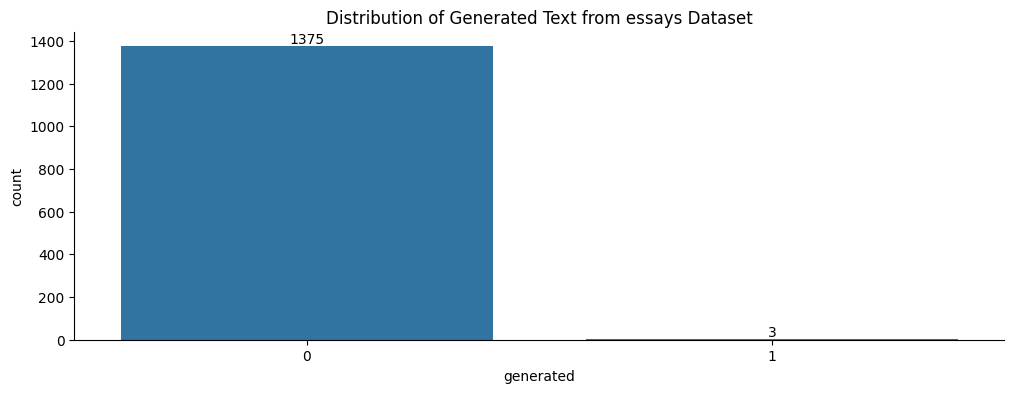

In [13]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=essays_df,
                   x="generated")

abs_values = essays_df['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text from essays Dataset")

In [14]:
gpt_df=pd.read_csv("data/argugpt.csv")

In [15]:
gpt_df.head()

,id,prompt_id,prompt,text,model,temperature,exam_type,score,score_level
0,weccl_30,WECCL-17,Some people think the university education is ...,There are many people who think that universit...,text-babbage-001,0.50,weccl,19,high
1,weccl_51,WECCL-17,Some people think the university education is ...,There are a number of reasons why people might...,text-babbage-001,0.65,weccl,13,medium
2,weccl_48,WECCL-17,Some people think the university education is ...,There are many reasons why university educatio...,text-babbage-001,0.65,weccl,13,medium
3,weccl_50,WECCL-17,Some people think the university education is ...,There are many people who think that universit...,text-babbage-001,0.65,weccl,12,low
4,weccl_55,WECCL-17,Some people think the university education is ...,There is a general consensus that university e...,text-babbage-001,0.80,weccl,13,medium


In [16]:

print("Prompt_id", gpt_df['prompt'].value_counts())
    # This shows only 2 prompts|




Prompt_id prompt
Most advertisements make products seem much better than they really are. Do you agree or disagree? Use specific reasons and examples to support your answer. Write an essay of roughly 400 words.                                                                        206
Successful people try new things and take risks rather than only doing what they already know how to do well. Do you agree or disagree? Use specific reasons and examples to support your answer. Write an essay of roughly 400 words.                                   205
It is better to have broad knowledge of many academic subjects than to specialize in one specific subject. Do you agree or disagree? Use specific reasons and examples to support your answer. Write an essay of roughly 400 words.                                      205
In twenty years, there will be fewer cars in use than there are today. Do you agree or disagree? Use specific reasons and examples to support your answer. Write an essay of rou

In [17]:
gpt_df['generated']=1
gpt_df['source']='gpt'
gpt_df=gpt_df[['prompt','text','source','generated']]

Text(0.5, 1.0, 'Distribution of Generated Text from GPT')

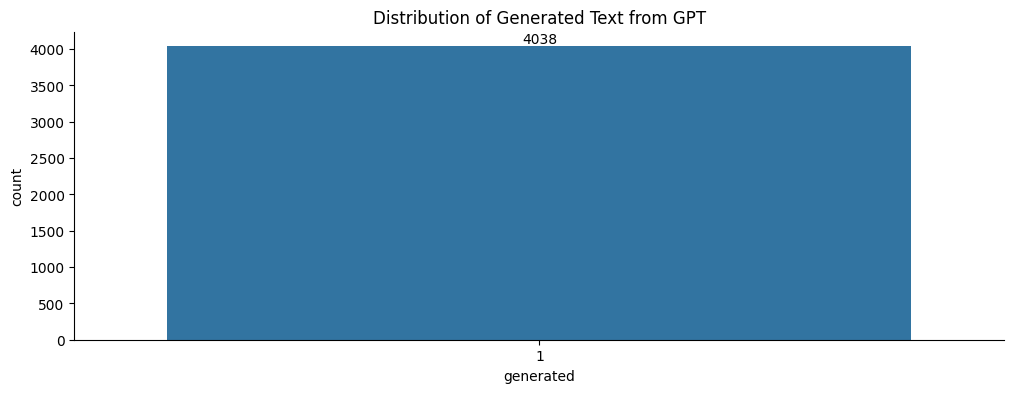

In [18]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=gpt_df,
                   x="generated")

abs_values = gpt_df['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text from GPT")

Add new data to the training dataset.
 We will use the dataset created by DAREK KŁECZEK

In [19]:
df_train_essays_ext = pd.read_csv('data/train_drcat_02.csv')
df_train_essays_ext.shape
df_train_essays_ext.rename(columns = {"label":"generated"}, inplace=True)

In [20]:
print("Prompt_id", df_train_essays_ext['generated'].value_counts())
    # This shows only 2 prompts

print("generated", df_train_essays_ext['source'].value_counts())

Prompt_id generated
0    29792
1     9993
Name: count, dtype: int64
generated source
persuade_corpus          25996
llama2_chat               2421
original_moth             2421
chat_gpt_moth             2421
llammistral7binstruct     2421
train_essays              1378
llama_70b_v1              1172
falcon_180b_v1            1055
radek_500                  500
Name: count, dtype: int64


In [21]:
df_train_essays_ext.head()

,essay_id,text,generated,source,prompt,fold
0,E0B86027C5C5,"Okay, here is my essay:\n\nWorking or doing th...",1,llama2_chat,Task: \n\n1. Research the benefits of working ...,1
1,8B9EEF86DD66,"Dear Principal,\r\n\r\nI just want to let you ...",0,original_moth,Task: Research the effects of implementing a p...,2
2,116FB053BEC7,I believe they should change the voting to pop...,0,persuade_corpus,NaN,9
3,A72A4397F9F5,One example of an inspiring individual who has...,1,chat_gpt_moth,Task: Analyze examples of inspiring people who...,0
4,D90A159EDD27,"Dear Mr. Principal,\n\nI believe that students...",0,persuade_corpus,NaN,5


In [22]:
df_train_essays_ext=df_train_essays_ext[['prompt','text','source','generated']]

Text(0.5, 1.0, 'Distribution of Generated Text from Train_Essays DataSet')

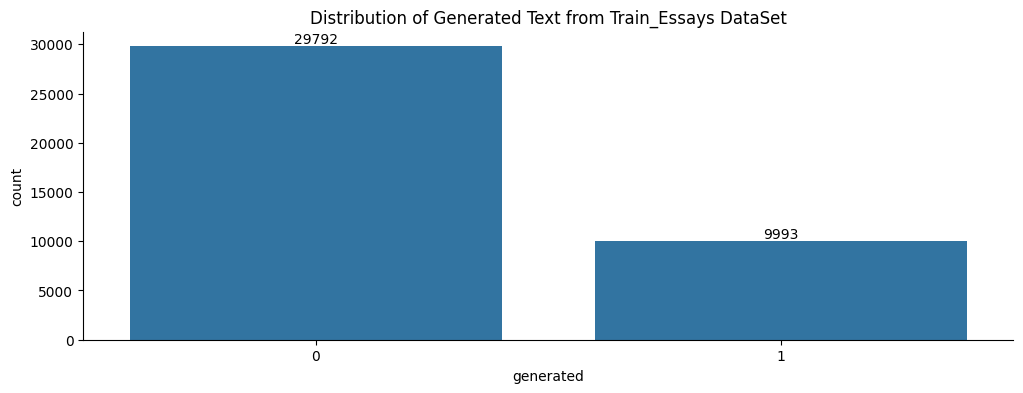

In [23]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays_ext,
                   x="generated")

abs_values = df_train_essays_ext['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text from Train_Essays DataSet")

In [24]:
df=pd.concat([essays_df,gpt_df,df_train_essays_ext])

In [25]:
df.head()

,prompt,text,source,generated
0,Write an explanatory essay to inform fellow ci...,Cars. Cars have been around since they became ...,human,0
1,Write an explanatory essay to inform fellow ci...,Transportation is a large necessity in most co...,human,0
2,Write an explanatory essay to inform fellow ci...,"""America's love affair with it's vehicles seem...",human,0
3,Write an explanatory essay to inform fellow ci...,How often do you ride in a car? Do you drive a...,human,0
4,Write an explanatory essay to inform fellow ci...,Cars are a wonderful thing. They are perhaps o...,human,0


In [26]:
print("Prompt_id", df_train_essays_ext['generated'].value_counts())


Prompt_id generated
0    29792
1     9993
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Generated Text From Entire DataFrame')

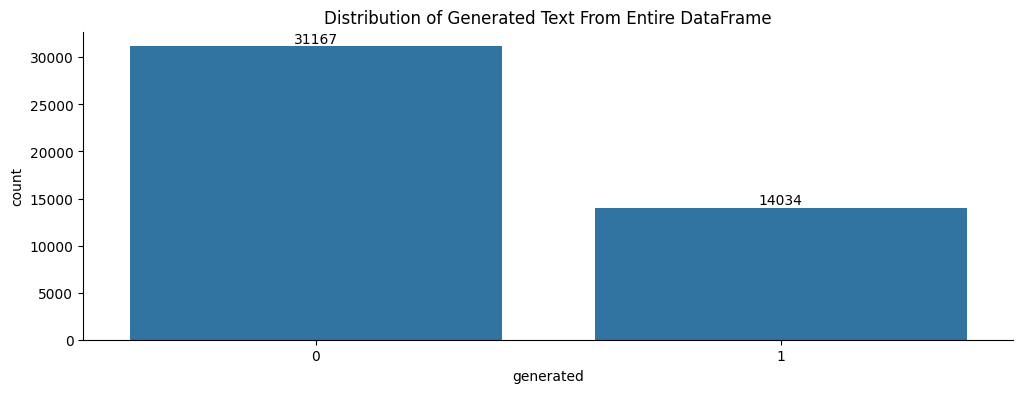

In [27]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df,
                   x="generated")

abs_values = df['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text From Entire DataFrame")

In [28]:
df.describe()

,generated
count,45201.000000
mean,0.310480
std,0.462695
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [29]:
df["text_length"] = df["text"].apply(lambda x : len(x.split()))


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45201 entries, 0 to 39784
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   prompt       14906 non-null  object
 1   text         45201 non-null  object
 2   source       45201 non-null  object
 3   generated    45201 non-null  int64 
 4   text_length  45201 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.1+ MB


Text(0.5, 0.98, 'Distribution of the length per essay - Train dataset')

<Figure size 3000x6000 with 0 Axes>

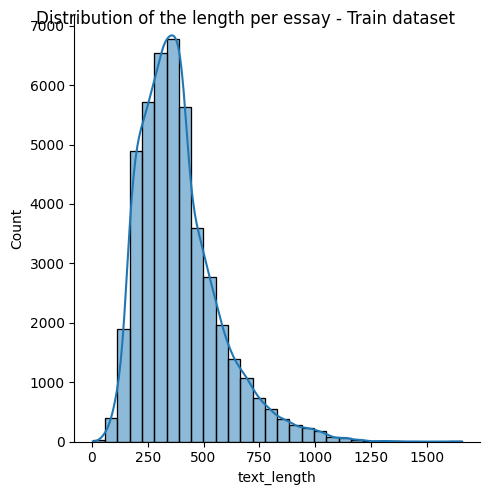

In [31]:
fig = plt.figure(figsize=(30,60))
plot = sns.displot(data=df,
                 x="text_length", bins=30, kde=True)
plot.fig.suptitle("Distribution of the length per essay - Train dataset")

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45201 entries, 0 to 39784
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   prompt       14906 non-null  object
 1   text         45201 non-null  object
 2   source       45201 non-null  object
 3   generated    45201 non-null  int64 
 4   text_length  45201 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 3.1+ MB


In [33]:

df['prompt'] = df['prompt'].astype(str)
df['source'] = df['source'].astype(str)
df['text'] = df['text'].astype(str)


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45201 entries, 0 to 39784
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   prompt       45201 non-null  object
 1   text         45201 non-null  object
 2   source       45201 non-null  object
 3   generated    45201 non-null  int64 
 4   text_length  45201 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 3.1+ MB


In [35]:

fig = px.scatter(df, x="text_length", y="generated",
                 title="Scatter Plot of Text Length vs. Generated")
fig.show()


In [36]:

fig = px.histogram(df, x="text_length", color="source",
                 title="Histogram of Count of Text Length by Source",
                 nbins=10)
fig.show()


In [37]:

fig = px.histogram(df, x="source", color="generated",y="text_length",
                 title="Distribution of Sum of Text Length by Source",
                 nbins=10)
fig.show()


In [38]:
X=df['text']
y=df['generated']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)


In [39]:

model=DummyClassifier()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy:",accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.69      1.00      0.82      6235
           1       0.00      0.00      0.00      2806

    accuracy                           0.69      9041
   macro avg       0.34      0.50      0.41      9041
weighted avg       0.48      0.69      0.56      9041

Accuracy: 0.689636102201084


In [40]:



english_words = set(words.words())

def my_tokenizer(text):
    tokens = nltk.word_tokenize(text)
    return [token for token in tokens if token.lower() in english_words]


vect_pipe_1 = Pipeline([('cvect',CountVectorizer(stop_words='english', tokenizer=my_tokenizer)),('lgr',LogisticRegression())])
X_train_vectpipe=vect_pipe_1.fit(X_train,y_train)
test_acc = vect_pipe_1.score(X_test,y_test)


In [41]:
y_pred=vect_pipe_1.predict(X_test)
print(y_pred)


[1 0 1 ... 1 0 0]


In [42]:
acc = accuracy_score(y_test, y_pred)


In [43]:
print(acc)

0.9870589536555691


In [44]:
# params = {'cvect__max_features': [100, 500],
#          'cvect__stop_words': ['english']   }

# grid = GridSearchCV(vect_pipe_1,params)
# grid.fit(X_train,y_train)

# test_acc = grid.score(X_test,y_test)
# print(grid.best_params_)
# print(grid.best_score_)
# print(test_acc)
# y_pred_grid=grid.predict(X_test)
# grid_acc = accuracy_score(y_test, y_pred_grid)


In [ ]:
tfidf = TfidfVectorizer()
dtm = tfidf.fit_transform(X_train)


x=pd.DataFrame(dtm.toarray(), columns = tfidf.get_feature_names_out()).head()
print(x)
# params = {'tfidf__max_features': [100, 500, 1000, 2000],
#          'tfidf__stop_words': ['english', None]}